<a href="https://colab.research.google.com/github/JackHe313/GAN_generate/blob/main/spotifly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Week 2 - Data Cleaning and EDA
---
---



In [ ]:
# Our team decided to use the Spotify dataset.
# The question we will be exploring is "Can we predict a song's popularity using its musical features?"
# Main features we will be using: track_id, popularity, explicit, danceability, energy, loudness, liveness, tempo, track_genre

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from mlxtend.evaluate import bias_variance_decomp

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100

df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In order to use the data with full confidence, some cleaning is needed. First, we checked for and filled in missing values with corresponding means, medians, and modes.

In [ ]:
# Check for missing values.
print("Missing values before cleaning:\n", df.isnull().sum())
print("\n")

# Drop rows where critical features like track_id or track_name are missing.
df_cleaned = df.dropna(subset=['track_id', 'track_name'])

# Key is a special feature. If a key cannot be determined, the key is assigned a value of -1.
missing_key_count = (df_cleaned['key'] == -1).sum()
print("Number of songs without a key: ", missing_key_count)

# Fill in missing numerical values with their corresponding feature's mean or median.
df_cleaned.loc[:, 'popularity'] = df_cleaned['popularity'].fillna(df_cleaned['popularity'].mean())
df_cleaned.loc[:, 'danceability'] = df_cleaned['danceability'].fillna(df_cleaned['danceability'].median())
df_cleaned.loc[:, 'energy'] = df_cleaned['energy'].fillna(df_cleaned['energy'].mean())
df_cleaned.loc[:, 'loudness'] = df_cleaned['loudness'].fillna(df_cleaned['loudness'].median())
df_cleaned.loc[:, 'liveness'] = df_cleaned['liveness'].fillna(df_cleaned['liveness'].mean())
df_cleaned.loc[:, 'tempo'] = df_cleaned['tempo'].fillna(df_cleaned['tempo'].mean())

# Fill missing categorical values with their corresponding feature's most common value (mode).
df_cleaned.loc[:, 'track_genre'] = df_cleaned['track_genre'].fillna(df_cleaned['track_genre'].mode()[0])
df_cleaned.loc[:, 'explicit'] = df_cleaned['explicit'].fillna(df_cleaned['explicit'].mode()[0])

# Verify that we have no more missing values.
print("\n\nMissing values after cleaning:\n", df_cleaned.isnull().sum())

Missing values before cleaning:
 Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


Number of songs without a key:  0


Missing values after cleaning:
 Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time

Then, we checked for outliers and removed duplicate data for the same track.

In [ ]:
# CHECK FOR OUTLIERS

# Speechiness
outlier_speechiness = df_cleaned[(df_cleaned['speechiness'] < 0) | (df_cleaned['speechiness'] > 1)]
print("Number of outliers in speechiness: ", outlier_speechiness.shape[0])

# Popularity
Q1 = df_cleaned['popularity'].quantile(0.25)
Q3 = df_cleaned['popularity'].quantile(0.75)
IQR = Q3 - Q1

outliers = df_cleaned[(df_cleaned['popularity'] < (Q1 - 1.5 * IQR)) | (df_cleaned['popularity'] > (Q3 + 1.5 * IQR))]
print("Number of outliers in popularity:", outliers.shape[0])

# CHECK FOR DUPLICATES

# Remove duplicates based on the track_id column.
df_cleaned = df_cleaned.drop_duplicates(subset=['track_id'])

# Verify that duplicates have been removed.
print("Number of duplicate track_id entries:", df_cleaned.duplicated(subset=['track_id']).sum())


Number of outliers in speechiness:  0
Number of outliers in popularity: 2
Number of duplicate track_id entries: 0


We generated a description of the data across all features.

In [ ]:
df_cleaned.select_dtypes('number').describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,89740.000000,89740.000000,8.974000e+04,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000
mean,53479.005739,33.198808,2.291444e+05,0.562166,0.634458,5.283530,-8.498994,0.636973,0.087442,0.328285,0.173415,0.216971,0.469474,122.058134,3.897426
std,33410.141924,20.580640,1.129458e+05,0.176692,0.256606,3.559912,5.221518,0.480875,0.113278,0.338321,0.323849,0.194885,0.262864,30.117651,0.453437
min,0.000000,0.000000,8.586000e+03,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23766.750000,19.000000,1.730400e+05,0.450000,0.457000,2.000000,-10.322250,0.000000,0.036000,0.017100,0.000000,0.098200,0.249000,99.262750,4.000000
50%,50680.500000,33.000000,2.132955e+05,0.576000,0.676000,5.000000,-7.185000,1.000000,0.048900,0.188000,0.000058,0.132000,0.457000,122.013000,4.000000
75%,80618.500000,49.000000,2.642930e+05,0.692000,0.853000,8.000000,-5.108000,1.000000,0.085900,0.625000,0.097625,0.279000,0.682000,140.077000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


We generated a histogram, heat map, and bar plot to visualize the distribution of popularity, correlation between numerical features and popularity, and the average popularity across different track genres, respectively.

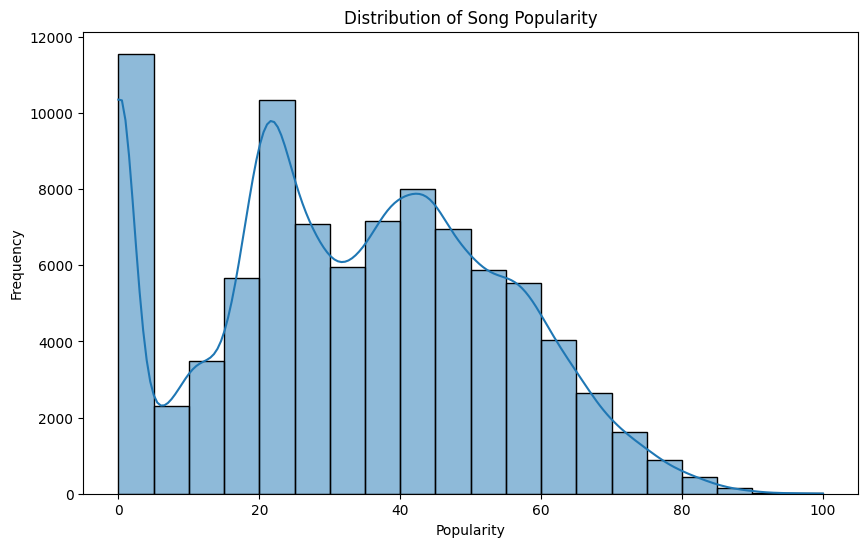

In [ ]:
# 1. Distribution of Popularity
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['popularity'], bins=20, kde=True)
plt.title('Distribution of Song Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

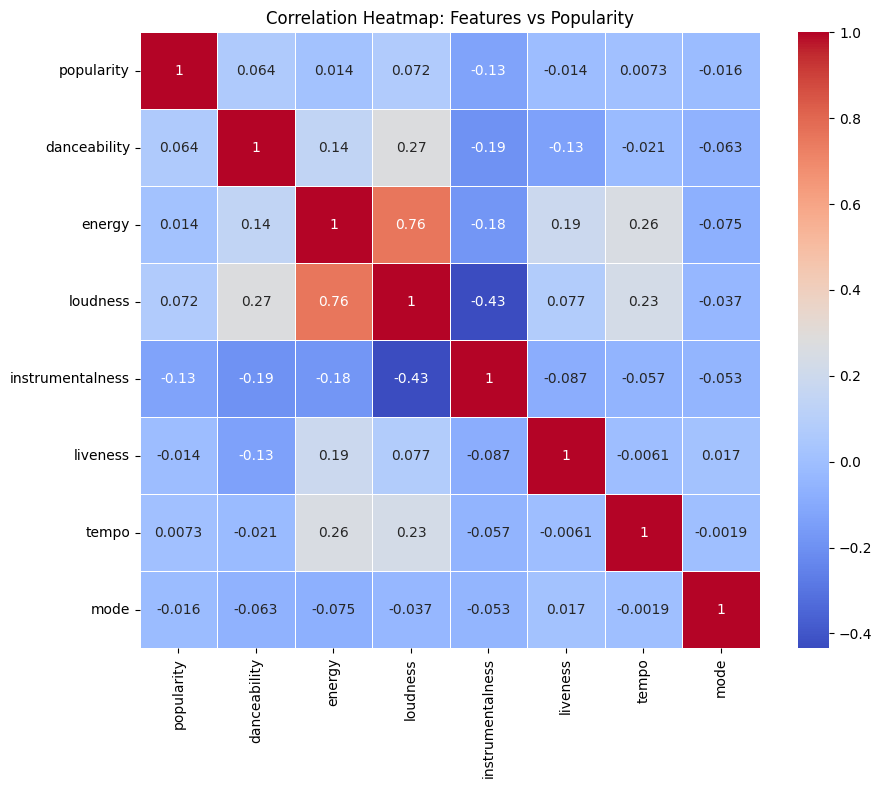

In [ ]:
# 2. Correlation Heatmap: Examine correlations between numerical features and popularity.
plt.figure(figsize=(10, 8))
correlation_matrix = df_cleaned[['popularity', 'danceability', 'energy', 'loudness', 'instrumentalness', 'liveness', 'tempo', 'mode']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap: Features vs Popularity')
plt.show()

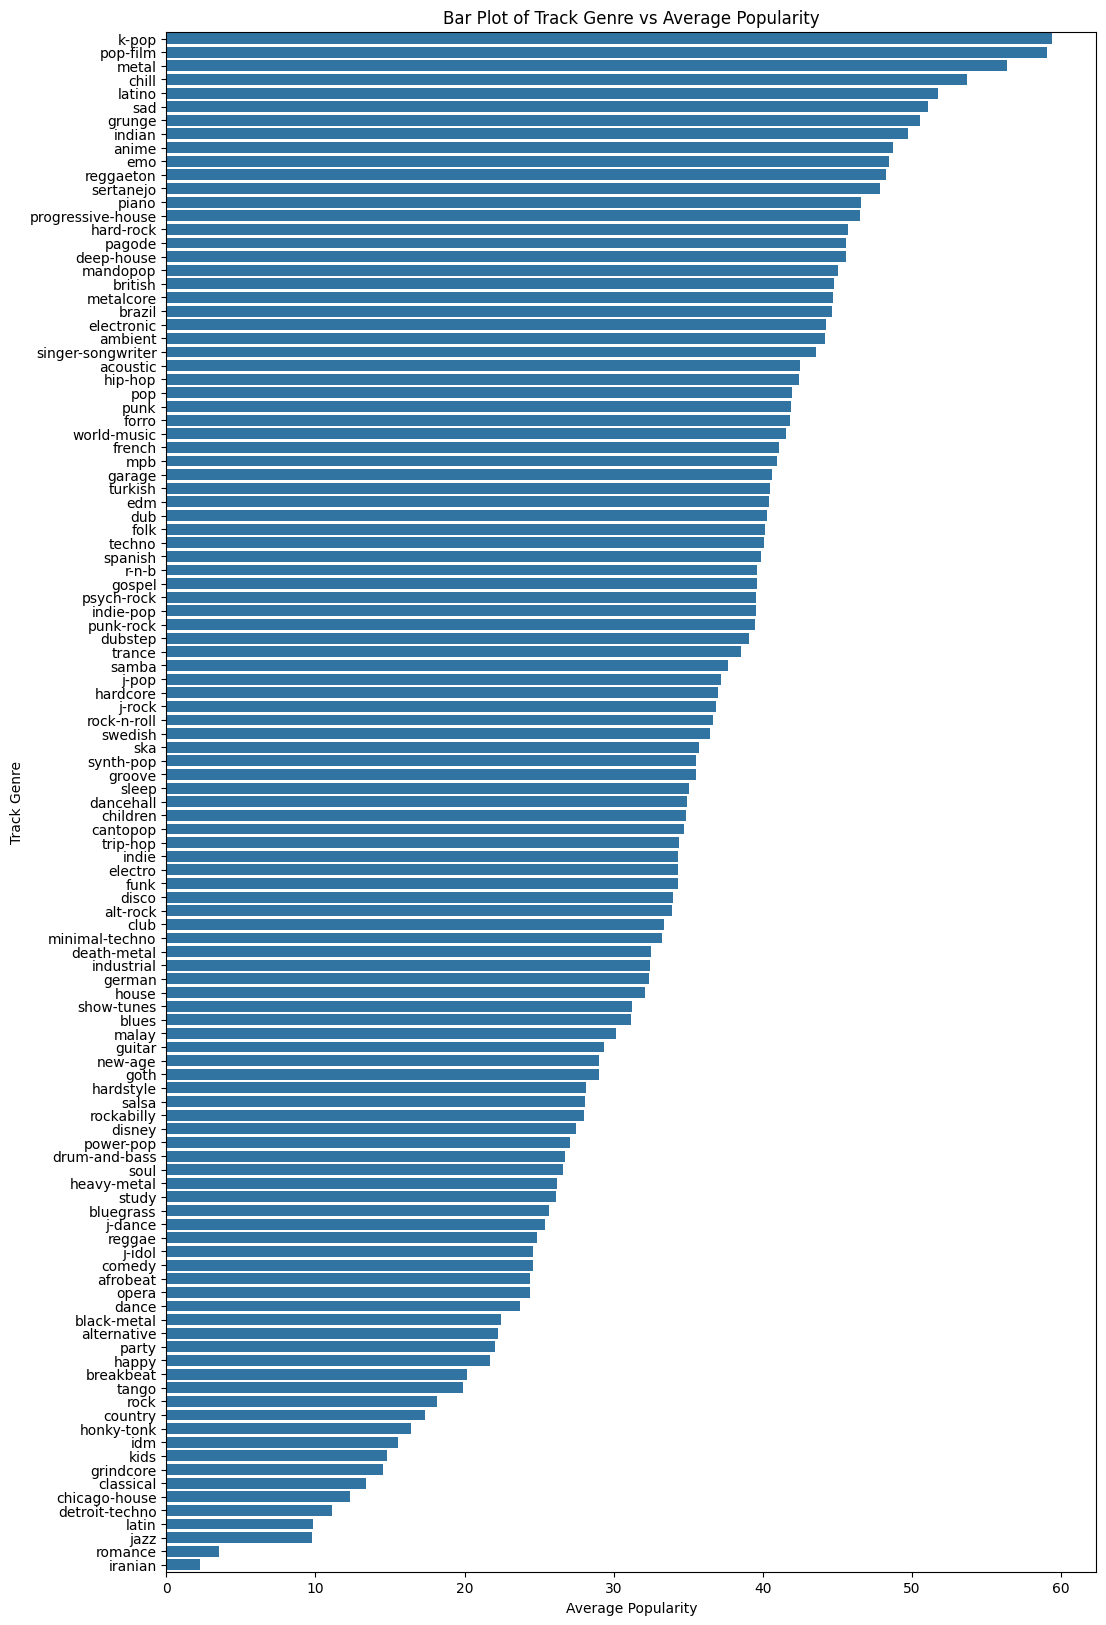

In [ ]:
# 3. Bar Plot: Compare the average popularity across different track genres.
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Group by track_genre and calculate their average popularity.
df_genre_popularity = df_cleaned.groupby('track_genre')['popularity'].mean().reset_index()

# Sort the genres by the average popularity in descending order.
df_genre_popularity = df_genre_popularity.sort_values(by='popularity', ascending=False)

# Set the figure size for better readability.
plt.figure(figsize=(12, 20))

# Create a bar plot to show the relationship between track_genre and average popularity.
sns.barplot(x='popularity', y='track_genre', data=df_genre_popularity)

# Add a title and labels.
plt.title('Bar Plot of Track Genre vs Average Popularity')
plt.xlabel('Average Popularity')
plt.ylabel('Track Genre')

# Show the plot.
plt.show()

Week 3 - Regression
---
---
**Splitting up the data**

As there was only 1 set given in the spotify dataset, we need to split it up for 70% training, 15% validation, and 15% testing.


In [ ]:
# training set takes 60% of cleaned data
spotify_train_processed = df_cleaned.sample(frac=0.7, random_state=42)
# validation takes half of what isn't in training set (20%)
spotify_val_processed = df_cleaned.drop(spotify_train_processed.index).sample(frac=0.5, random_state=42)
# # testing data is the other half of what is not in training set (20%)
spotify_test_processed = df_cleaned.drop(spotify_train_processed.index).drop(spotify_val_processed.index)

# Checking shape of each dataset
print("Training set shape:", spotify_train_processed.shape)
print("Validation set shape:", spotify_val_processed.shape)
print("Testing set shape:", spotify_test_processed.shape)

# Checking for data leakage

combined_sets = pd.concat([spotify_train_processed, spotify_val_processed, spotify_test_processed])

duplicates = combined_sets.duplicated(subset=['track_id']).sum()
print("Number of duplicate rows accross training, validation, and set:", duplicates)

Training set shape: (62818, 21)
Validation set shape: (13461, 21)
Testing set shape: (13461, 21)
Number of duplicate rows accross training, validation, and set: 0


**Preparing to model our regression**


---


In order to further our knowledge on regression, we will be building a mini-model that will contain energy as the response variable.

In order to choose predictor variables for our model, we will select variables through forward selection.

In [ ]:
# Here we write forward selection algorithm from scratch
# Choosing 4 features from the 11 numerical predictor variables
X = spotify_train_processed[['duration_ms','loudness','key','liveness','speechiness','acousticness','instrumentalness','valence', 'danceability','tempo']]
y = np.array(spotify_train_processed['energy'])

# Initialize variables
selected_features = []
best_mse = float('inf')

desired_num_features = 2

# Forward selection loop
while len(selected_features) < desired_num_features:
    best_feature = None
    for feature in X.columns:
        if feature not in selected_features:
            candidate_features = selected_features + [feature]
            model = LinearRegression().fit(X[candidate_features], y)
            mse = mean_squared_error(y, model.predict(X[candidate_features]))
            if mse < best_mse:
                best_mse = mse
                best_feature = feature

    if best_feature:
        selected_features.append(best_feature)
        print(f"Selected feature: {best_feature}, MSE: {best_mse}")
    else:
        break

print(f"Final selected features: {selected_features}")

Selected feature: loudness, MSE: 0.02781644191670256
Selected feature: acousticness, MSE: 0.019419782723602015
Final selected features: ['loudness', 'acousticness']


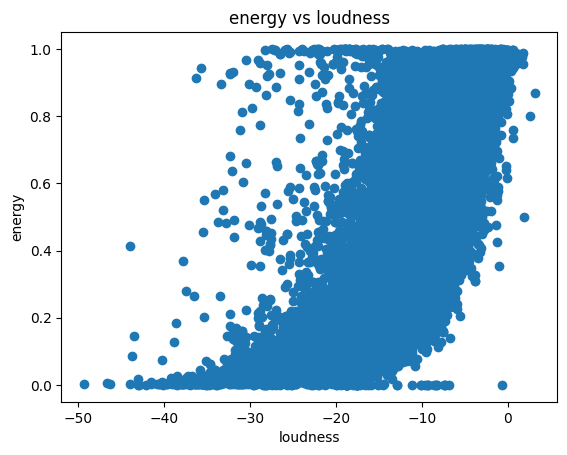

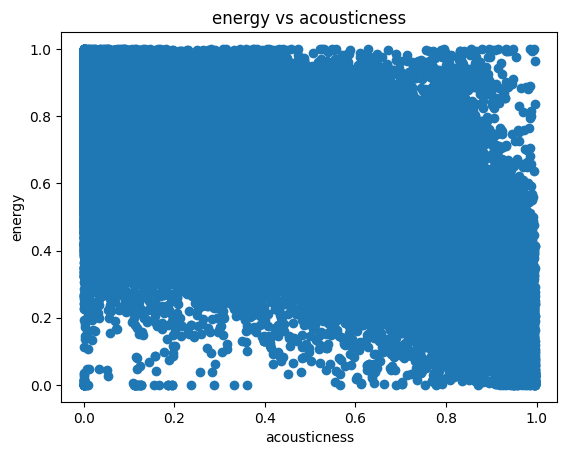

In [ ]:
# Sample data
loudness = spotify_train_processed['loudness'].values
acousticness = spotify_train_processed['acousticness'].values
energy = spotify_train_processed['energy'].values

# Creating a scatter plot
plt.scatter(loudness, energy)
plt.title('energy vs loudness')
plt.xlabel('loudness')
plt.ylabel('energy')
plt.show()

plt.scatter(acousticness, energy)
plt.title('energy vs acousticness')
plt.xlabel('acousticness')
plt.ylabel('energy')
plt.show()

In [ ]:
# Initialize the model
# danceability predictor using linear regression

dan_lin_fit = LinearRegression()

# X_train = np.array(spotify_train_processed[selected_features]).reshape(-1, len(selected_features))
X_train = spotify_train_processed[selected_features].values
y_train = spotify_train_processed['energy'].values

# Fit the model with multiple features (X) and target variable (y)
dan_lin_fit.fit(X=X_train,
            y=y_train)

# Display the intercept and coefficients
print("Intercept:", dan_lin_fit.intercept_)
print("Coefficients:", dan_lin_fit.coef_)

Intercept: 0.9547429712795872
Coefficients: [ 0.02483492 -0.33367607]


In [ ]:
from mlxtend.evaluate import bias_variance_decomp

# Predictor variables from validation and training
X_valid = spotify_val_processed[selected_features].values
X_test = spotify_test_processed[selected_features].values

# validation + testing actual energy
y_valid = spotify_val_processed['energy'].values
y_test = spotify_test_processed['energy'].values

# validation + testing predicted energy
y_valid_pred = dan_lin_fit.predict(X_valid)
y_test_pred = dan_lin_fit.predict(X_test)


avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        dan_lin_fit, X_train, y_train, X_valid, y_valid,
        loss='mse',
        random_seed=123)


print('Square root of Average expected loss: %.3f' % np.sqrt(avg_expected_loss))
print('Average bias: %.3f' % np.sqrt(avg_bias))
print('Average std: %.3f' % np.sqrt(avg_var))



Square root of Average expected loss: 0.140
Average bias: 0.140
Average std: 0.001


**Analyzing the Data**

As a result of looking at the bias and variance compared to the average expected loss, we can see that are model severely underfits the data, as most of the error is due to bias.

This is most likely due to the fact that we are using a linear model for regression.




---
**Regularization of a model**


In [ ]:
from sklearn.linear_model import  Ridge, Lasso
from sklearn.model_selection import cross_val_score, cross_validate


# scale the predictors
X = X.select_dtypes(include=[np.number])
X_std = (X - X.mean()) / X.std()
y = spotify_train_processed['energy']


# use 10-fold cross-validation to select the best lambda (alpha) value for the ridge regression model

# define the alpha values to test
# note that the start/stop values in the first two arguments are the exponents
alphas = np.logspace(-1, 6, 100)

# create an empty list to store the cross-validation scores
ridge_cv_scores = []

# create a for loop to compute the cross-validation score for each alpha value
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge_cv = cross_validate(estimator=ridge,
                              X=X_std,
                              y=y,
                              cv=10,
                              scoring='neg_root_mean_squared_error')
    ridge_cv_scores.append({'alpha': alpha,
                            'log_alpha': np.log(alpha),
                            'test_mse': -np.mean(ridge_cv['test_score'])})

# convert the cross-validation scores into a data frame
ridge_cv_scores_df = pd.DataFrame(ridge_cv_scores)

# plot the cross-validation scores as a function of alpha
px.line(ridge_cv_scores_df,
        x='log_alpha',
        y='test_mse',
        title='Ridge')

In [ ]:
# identify the value of alpha that minimizes the cross-validation score for ridge
ridge_alpha_min = ridge_cv_scores_df.sort_values(by='test_mse').head(1).alpha.values[0]
# compute the min MSE and the SE of the MSE
mse_se_ridge = ridge_cv_scores_df['test_mse'].std() / np.sqrt(10)
mse_min_ridge = ridge_cv_scores_df['test_mse'].min()


# identify the value of alpha that minimizes the cross-validation score for ridge within 1SE
ridge_alpha_1se = ridge_cv_scores_df[(ridge_cv_scores_df['test_mse'] <= mse_min_ridge + mse_se_ridge) &
                                     (ridge_cv_scores_df['test_mse'] >= mse_min_ridge - mse_se_ridge)].sort_values(by='alpha', ascending=False).head(1).alpha.values[0]

In [ ]:
# use ridge_alpha_min to fit the ridge regression model
ridge_min_fit = Ridge(alpha=ridge_alpha_min).fit(X=X_std, y=y)
ridge_1se_fit = Ridge(alpha=ridge_alpha_1se).fit(X=X_std, y=y)

X_valid = spotify_val_processed[['duration_ms','loudness','key','liveness','speechiness','acousticness','instrumentalness','valence', 'danceability','tempo']]
X_valid = X_valid.select_dtypes(include=[np.number])
X_valid_std = (X_valid - X_valid.mean()) / X_valid.std()

y_valid = spotify_val_processed['energy'].fillna(y.mean())

# avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
#         ridge_min_fit, X_std.values, y.values, X_valid_std.values, y_valid.values,
#         loss='mse',
#         random_seed=123)


print('Square root of Average expected loss: %.3f' % np.sqrt(avg_expected_loss))
print('Average bias: %.3f' % np.sqrt(avg_bias))
print('Average std: %.3f' % np.sqrt(avg_var))

Square root of Average expected loss: 0.140
Average bias: 0.140
Average std: 0.001


As the model was already underfitted, the regularization techniques weren't able to do much.

This is likely because of the linear regression that we are using, as the relationships are most likely not linear.

**Week 4 - Logistic Regression**
---



---

This week we are running a logistic regression. As logistic regression is typically used to make a binary prediction, we will use the 'mode' variable as the response. The mode variable is 1 if the song is in a major key, and 0 if it is in a minor key. This regression will test if you can predict if a song is in a major or minor key based on other features of the song.

In [ ]:
df_sample = df_cleaned.sample(n=15, random_state=42)
df_sample

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
67141,67141,0wJMDTFRqqzYfBu1LbNBeY,Feid,Homecoming Latin Party,Feliz Cumpleaños Ferxxo,0,155960,False,0.865,0.573,5,-5.501,1,0.0678,0.08630,0.000000,0.3050,0.563,94.999,4,latin
107395,107395,1VKnVxZZnubjTEJG6Tme1y,Papa Dance,Papa Dance,Kamikadze wróć!,30,220266,False,0.786,0.866,11,-9.756,1,0.0399,0.28600,0.000000,0.2450,0.967,129.212,4,synth-pop
19476,19476,3Lu4WAsmpag6CZSN0H3Wor,Steely Dan,Fiesta temática 70s,Do It Again,0,354933,False,0.695,0.583,2,-8.265,0,0.0303,0.15700,0.000076,0.0576,0.960,124.610,4,country
74084,74084,5HaAOqKwmgyXNAZKGVhdsS,Renato Teixeira,Renato Teixeira Obra Completa na RCA de 1978 a 1982 (Remasterizado),Romaria - Remasterizado,47,243466,False,0.505,0.346,2,-10.300,1,0.0263,0.60000,0.000003,0.0787,0.377,92.412,3,mpb
108906,108906,3TjXPh8bOY0K6K5WnReqH8,Esteban Morgado,Milongueros,Oblivion,16,305680,False,0.366,0.465,2,-4.685,0,0.0296,0.62600,0.004160,0.1610,0.353,116.530,4,tango
52748,52748,1cmEK62km406VcXO88x4Gy,George Jones,The New Favorites Of George Jones,What Am I Worth,12,128306,False,0.577,0.712,7,-7.401,1,0.0500,0.57200,0.000000,0.1070,0.964,89.380,4,honky-tonk
104751,104751,4FrThBco0jLqXEMULUhSM9,Alberto Gambino,Purpurina,Purpurina,59,192000,False,0.890,0.643,9,-6.093,1,0.0688,0.13500,0.000000,0.2410,0.970,132.080,4,spanish
79447,79447,2T7qCmVQfFrh0ihKjprF45,Starsailor,Alternative Rock Mixtape,Four to the Floor,2,230960,False,0.530,0.782,1,-6.872,0,0.0259,0.02650,0.000187,0.0688,0.719,93.106,4,piano
88191,88191,5Hc5uFMVvvtc9YYJmXtspy,KAROL G,Perreo Tenebroso Vol. 2,A Ella,0,198720,False,0.730,0.769,2,-4.936,1,0.1780,0.24400,0.000021,0.1360,0.594,181.988,4,reggae
98941,98941,5WJbJxnjFhH1KzVnKICAvh,Claude-Michel Schönberg;Claire Moore,Highlights From Miss Saigon,Her Or Me,20,203573,False,0.222,0.131,4,-14.796,1,0.0376,0.81300,0.000025,0.1760,0.158,182.168,1,show-tunes


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Dropping descriptive or categorical variables
X = df_cleaned.drop(columns=['track_id', 'album_name', 'artists','track_name', 'track_genre', 'explicit', 'mode'])

# mode is the response variable
mode = df_cleaned['mode']

# Split the data into training and testing sets
# 60% train
X_train, X_val, mode_train, mode_val = train_test_split(X, mode, test_size=0.4, random_state=42)
# 20% val, 20% test
X_val, X_test, mode_val, mode_test = train_test_split(X_val, mode_val, test_size=0.5, random_state=42)


# Forward selection of variables

# Initialize variables
selected_features = []
best_log_loss = float('inf')

desired_num_features = 6

# Forward selection loop
while len(selected_features) < desired_num_features:
    best_feature = None
    for feature in X_train.columns:
        if feature not in selected_features:
            candidate_features = selected_features + [feature]
            model = LogisticRegression(solver='liblinear', max_iter=500).fit(X_train[candidate_features], mode_train)
            # Choose variables based on the log loss of the variable
            log_loss = metrics.log_loss(mode_train, model.predict_proba(X_train[candidate_features]))
            if log_loss < best_log_loss:
                best_log_loss = log_loss
                best_feature = feature

    if best_feature:
        selected_features.append(best_feature)
        print(f"Selected feature: {best_feature}, Log_loss: {best_log_loss}")
    else:
        break

print(f"Final selected features: {selected_features}")

X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

lr_fwd_sel = LogisticRegression(solver='liblinear')
lr_fwd_sel.fit(X_train, mode_train)

print('Coefficients: ', lr_fwd_sel.coef_, '\nIntercept: ', lr_fwd_sel.intercept_)

Selected feature: key, Log_loss: 0.6452909619848999
Selected feature: acousticness, Log_loss: 0.6413074512496132
Selected feature: instrumentalness, Log_loss: 0.6395308605951633
Selected feature: danceability, Log_loss: 0.6380019664263529
Selected feature: valence, Log_loss: 0.6366919806465047
Selected feature: speechiness, Log_loss: 0.6358955929524989
Final selected features: ['key', 'acousticness', 'instrumentalness', 'danceability', 'valence', 'speechiness']
Coefficients:  [[-0.08327712  0.55705995 -0.38039781 -0.93802386  0.47054438 -0.73668049]] 
Intercept:  [1.27684285]


In [ ]:
pred_val = pd.DataFrame(dict(
    mode = mode_val,
    lr_predict = lr_fwd_sel.predict_proba(X_val)[:,1],
    lr_predict_binary = lr_fwd_sel.predict(X_val)))
pred_val

,mode,lr_predict,lr_predict_binary
55219,1,0.631192,1
27618,0,0.536032,1
100945,1,0.771239,1
22535,1,0.598941,1
21112,1,0.700049,1
...,...,...,...
9003,0,0.493062,0
101112,1,0.738636,1
22216,1,0.709475,1
45450,1,0.640905,1


Confusion matrix: Will tell us the number (from top left to bottom right), of true negatives, false negatives, false positives, and false negatives.

In [ ]:
conf_lr = metrics.confusion_matrix(y_true=pred_val['mode'],
                                   y_pred=pred_val['lr_predict_binary'])
conf_lr

array([[  876,  5617],
       [  690, 10765]])

We can get a reading on the accuracy, true positive, and true negative rate:



In [ ]:
# accuracy
accuracy = metrics.accuracy_score(y_true=pred_val['mode'],
                       y_pred=pred_val['lr_predict_binary'])

# true positive rate
true_positive = metrics.recall_score(y_true=pred_val['mode'],
                     y_pred=pred_val['lr_predict_binary'])

# true negative rate
true_negative = metrics.recall_score(y_true=pred_val['mode'],
                     y_pred=pred_val['lr_predict_binary'],
                     pos_label=0)


accuracy, true_positive, true_negative

(0.6485959438377535, 0.939764295067656, 0.13491452333281995)

After looking at the confusing matrix, we can see that the model leans HEAVILY towards preficting a major key, which isn't a good sign. Even after using the forward selection with log_loss function, the variables we use don't seem to really be able to properly predict whether a song is major or minor.

In the actual dataset itself, there is 63.8 percent of songs being in a major key, and our predictor guesses 64.8 percent of songs correctly.


In [ ]:
px.histogram(pred_val, x='lr_predict', color='mode',
             nbins=20, opacity=0.5,
             barmode='overlay')


It can be seen how the model has a tough time of guessing whether a song is in a major or minor key, as the graph shows that the model predicts a vast majority of songs to be major, given that the threshold is 0.5.

In [ ]:
false_pos_rate, true_pos_rate, thresholds = metrics.roc_curve(y_true=pred_val['mode'],
                                                             y_score=pred_val['lr_predict'])

roc_lr = pd.DataFrame({
    'False Positive Rate': false_pos_rate,
    'True Positive Rate': true_pos_rate,
    'Model': 'Logistic Regression'
}, index=thresholds)

px.line(roc_lr, x='False Positive Rate', y='True Positive Rate',
        title='ROC Curve for Logistic Regression')

In order to find the best threshold, we should probably look at the highest difference between the true positive rate and the false positive rate.

This would mean that we are correctly predicting the most positives while also correctly predicting the most negatives.

In [ ]:
optimal_index = (true_pos_rate - false_pos_rate).argmax()
optimal_threshold = thresholds[optimal_index]

print("Optimal Threshold:", optimal_threshold)

Optimal Threshold: 0.6358797693956068
